# Pneumonia & Brain Tumor Detection using custom pooling methods

#### What is Pneumonia?

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

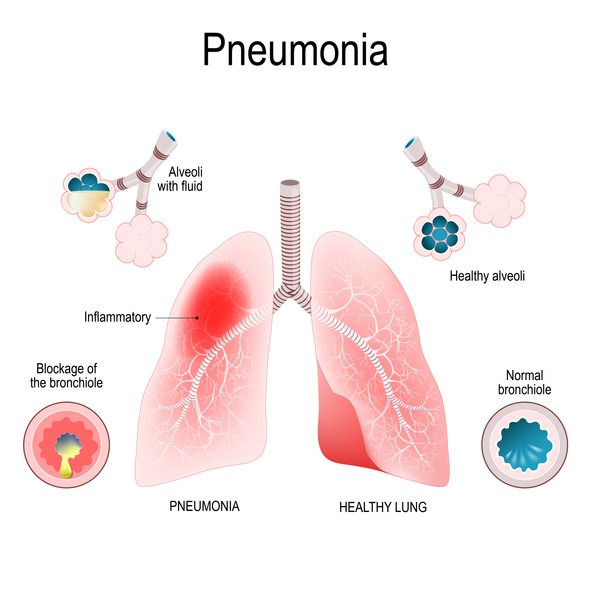

In [ ]:
# Import necessary libraries

import keras, cv2, os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.random as tfr
from google.colab import files
from google.colab import drive
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.models import Model, load_model
from keras import initializers
from keras import optimizers
from keras import layers
from keras.layers import *
from keras.layers import Dense,Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from keras.preprocessing import image
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from imutils import paths

seed = 0

np.random.seed(seed) 
random.seed(seed)
tfr.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['PROJ_CONFIG_DIR'] = "/content/gdrive/My Drive/Project"

In [ ]:
%cd /content/gdrive/My Drive/Project/

/content/gdrive/My Drive/Project


##Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [ ]:
# Find and load normal image directories into a list

directory_test = '/content/gdrive/MyDrive/Project/chest_xray/test/NORMAL/'
directory_train = '/content/gdrive/MyDrive/Project/chest_xray/train/NORMAL/'
directory_val = '/content/gdrive/MyDrive/Project/chest_xray/val/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [ ]:
# Find and load pneumonia image directories into a list
directory_test_pn = '/content/gdrive/MyDrive/Project/chest_xray/test/PNEUMONIA/'
directory_train_pn = '/content/gdrive/MyDrive/Project/chest_xray/train/PNEUMONIA/'
directory_val_pn = '/content/gdrive/MyDrive/Project/chest_xray/val/PNEUMONIA/'
image_paths_pn = sorted(list(paths.list_images(directory_test_pn))) + \
                 sorted(list(paths.list_images(directory_train_pn))) + \
                 sorted(list(paths.list_images(directory_val_pn)))

# Declare a pneumonia label list for binary
labels_pn = ['Pneumonia'] * len(image_paths_pn)

# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

## Exploratory Data Analysis and Visualization

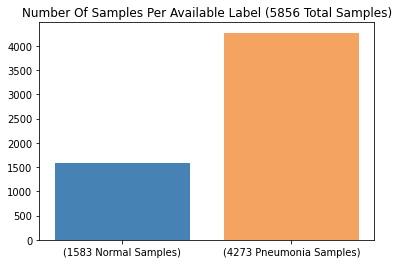

In [ ]:
# Plot a bar with numbers of normal and pneumonia diagnoses
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['#4682B4', '#F4A460'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

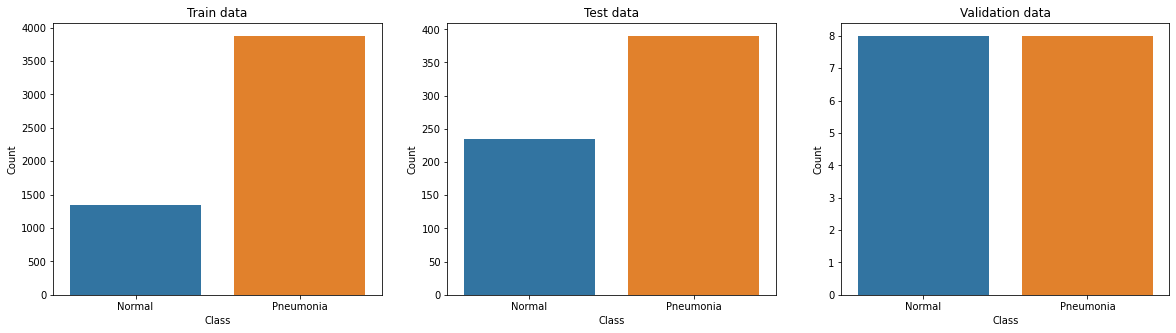

In [ ]:
# Train, Test and val distribution between the two classes

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data1 = [['Normal', len(list(paths.list_images(directory_train)))], ['Pneumonia', len(list(paths.list_images(directory_train_pn)))]]
df1 = pd.DataFrame(data1, columns=['Class', 'Count'])

sns.barplot(x=df1['Class'], y=df1['Count']);
plt.title('Train data')

plt.subplot(1,3,2)
data2 = [['Normal', len(list(paths.list_images(directory_test)))], ['Pneumonia', len(list(paths.list_images(directory_test_pn)))]]
df2 = pd.DataFrame(data2, columns=['Class', 'Count'])

sns.barplot(x=df2['Class'], y=df2['Count']);
plt.title('Test data')

plt.subplot(1,3,3)
data3 = [['Normal', len(list(paths.list_images(directory_val)))], ['Pneumonia', len(list(paths.list_images(directory_val_pn)))]]
df3 = pd.DataFrame(data3, columns=['Class', 'Count'])

sns.barplot(x=df3['Class'], y=df3['Count']);
plt.title('Validation data')

plt.show()

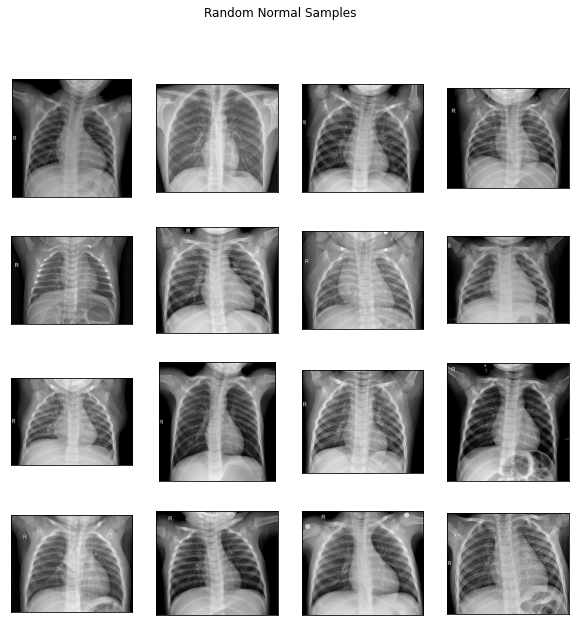

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
plt.rcParams["figure.figsize"] = (10, 10)

# Build a 4 x 4 figure
rows, columns = 4, 4
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

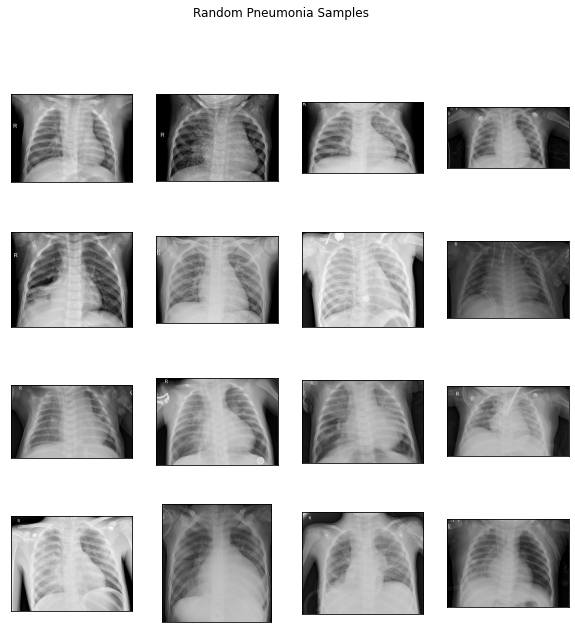

In [ ]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('Random Pneumonia Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

##Data preprocessing

In [ ]:
# The data distribution is 70% training and 15% validation & test data

# Divide the image path & label arrays into train & test sets
X_train_dir, X_test_dir, y_train, y_test = train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], y_test[len(y_test) // 2:]

print(X_train_dir.shape,y_train.shape),
print(X_val_dir.shape,y_val.shape),
print(X_test_dir.shape,y_test.shape)

(4099,) (4099,)
(878,) (878,)
(879,) (879,)


In [ ]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

In [ ]:
%pwd

'/content/gdrive/MyDrive/Project'

In [ ]:
# save the train, validation & test data

import pickle

# Open a file to write the pickled object
with open('train_df', 'wb') as train:
  # Pickle the object
  pickle.dump(train_df, train)

with open('val_df', 'wb') as val:
  # Pickle the object
  pickle.dump(val_df, val)

with open('test_df', 'wb') as test:
  # Pickle the object
  pickle.dump(test_df, test)

In [ ]:
# Open the file containing the pickled object

import pickle

with open('train_df', 'rb') as f:
  # Load the object from the file
  train_df = pickle.load(f)


with open('val_df', 'rb') as f:
  # Load the object from the file
  val_df = pickle.load(f)


with open('test_df', 'rb') as f:
  # Load the object from the file
  test_df = pickle.load(f)

In [ ]:
train_df.head()

filename      class
0  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
1  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
2  /content/gdrive/MyDrive/Project/chest_xray/tra...     Normal
3  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
4  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia

In [ ]:
test_df.head()

filename      class
0  /content/gdrive/MyDrive/Project/chest_xray/tra...     Normal
1  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
2  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
3  /content/gdrive/MyDrive/Project/chest_xray/tra...     Normal
4  /content/gdrive/MyDrive/Project/chest_xray/tra...     Normal

In [ ]:
val_df.head()

filename      class
0  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
1  /content/gdrive/MyDrive/Project/chest_xray/tes...  Pneumonia
2  /content/gdrive/MyDrive/Project/chest_xray/tra...     Normal
3  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia
4  /content/gdrive/MyDrive/Project/chest_xray/tra...  Pneumonia

##Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# Set the batch size for the generator and training
BATCH_SIZE = 32

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [ ]:
# with open('datagen.pickle', 'wb') as f:
#   # Pickle the object
#   pickle.dump(datagen, f)

In [ ]:
# # Open the file containing the pickled object
# with open('datagen.pickle', 'rb') as f:
#   # Load the object from the file
#   datagen = pickle.load(f)



# datagen.compile()

### Augmented images

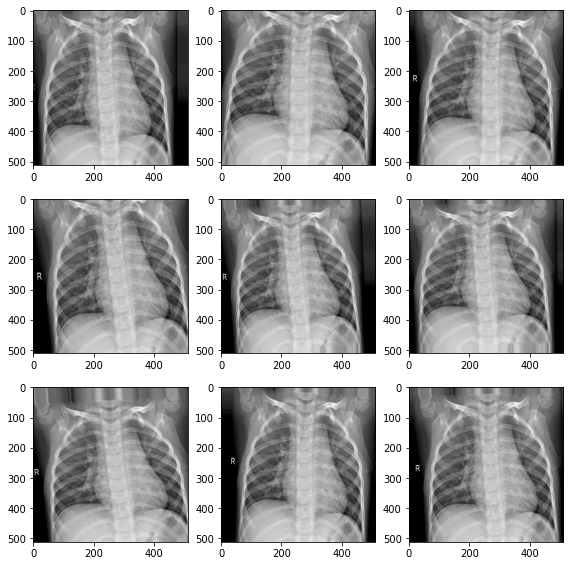

In [ ]:
# Show augmented images

def plotImages(images_arr):
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0],cmap="gray")
    plt.tight_layout()
    plt.show()

augmented_images = [train_gen[0][0][0] for i in range(1,10)]
plotImages(augmented_images)

# Model 1 with Max pooling

**Max pooling** is used to reduce the spatial dimensions of an image while retaining the most important information. It works by dividing the image into a set of non-overlapping regions (known as pooling regions or filters), and then selecting the maximum value within each region as the representative value for that region.

In [ ]:
model4=Sequential()

model4.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))


model4.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model4.add(Dropout(0.1))

model4.add(GlobalAveragePooling2D())

model4.add(Dense(units=1,activation='sigmoid'))

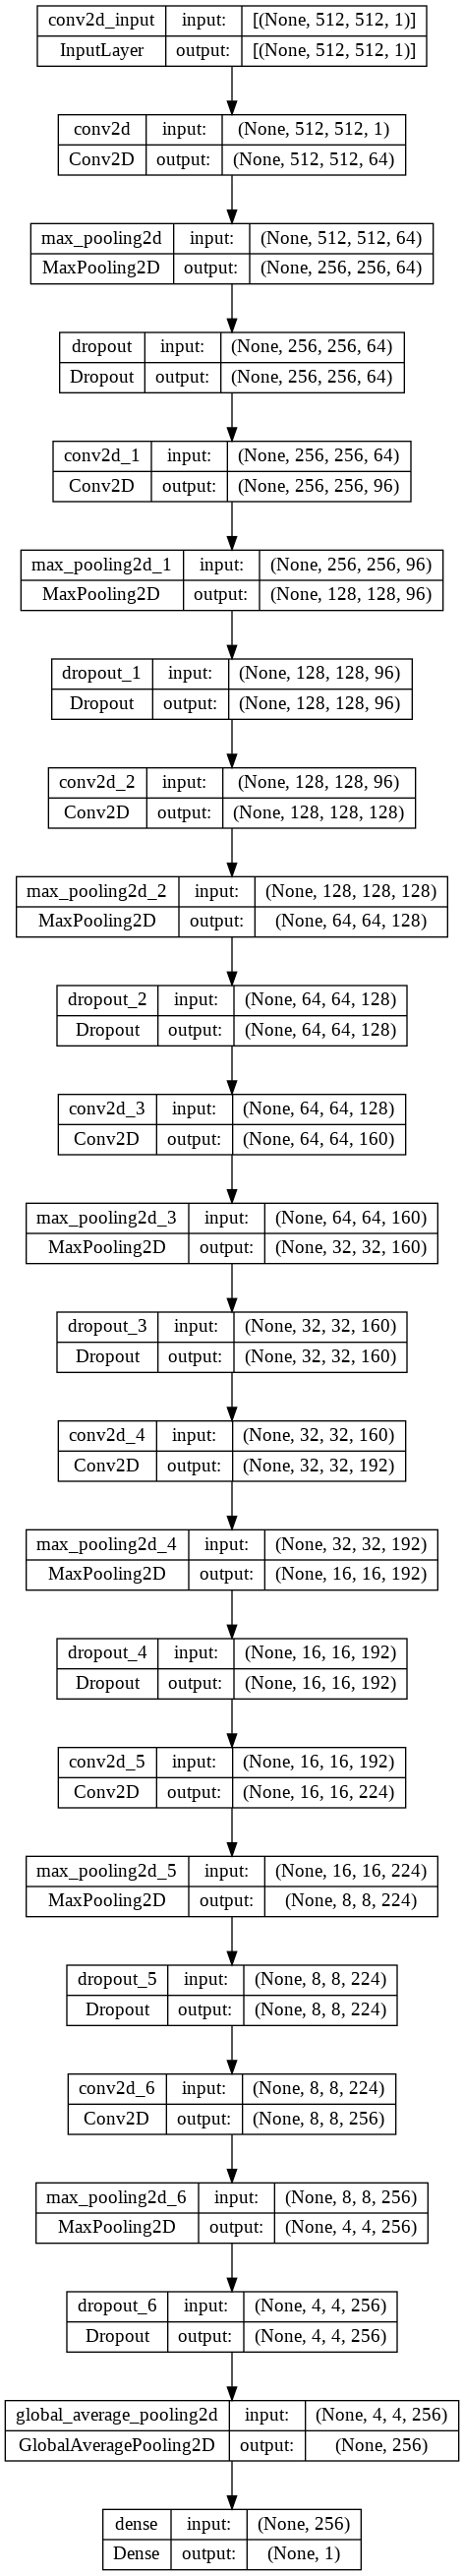

In [ ]:
# See graphical representation of the model
plot_model(model4, show_shapes=True)

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='CnnBestModel4.hdf5')

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
history4 = model4.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 1045s 8s/step - loss: 0.3897 - accuracy: 0.8028 - val_loss: 0.2893 - val_accuracy: 0.8785 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 133s 1s/step - loss: 0.2936 - accuracy: 0.8748 - val_loss: 0.2059 - val_accuracy: 0.9236 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 130s 1s/step - loss: 0.2195 - accuracy: 0.9130 - val_loss: 0.1933 - val_accuracy: 0.9375 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 133s 1s/step - loss: 0.1911 - accuracy: 0.9331 - val_loss: 0.2018 - val_accuracy: 0.9317 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.

In [ ]:
# Load saved model
load_model4 = tf.keras.models.load_model(filepath='CnnBestModel4.hdf5')

#### Model 1 - Test accuracy

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
load_model4.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 11s 379ms/step - loss: 0.1180 - accuracy: 0.9525


[0.11799231916666031, 0.9525462985038757]

#### Model 1 - Classification report

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = load_model4.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

27/27 [==============================] - 11s 386ms/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

Precision with test data: 0.9741936
Recall with test data: 0.9602544


In [ ]:
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

      Normal       0.90      0.93      0.91       235
   Pneumonia       0.97      0.96      0.97       629

    accuracy                           0.95       864
   macro avg       0.94      0.95      0.94       864
weighted avg       0.95      0.95      0.95       864



In [ ]:
fpr,tpr,threshold=roc_curve(y_true,y_pred)

In [ ]:
roc_auc=roc_auc_score(y_true,y_pred)

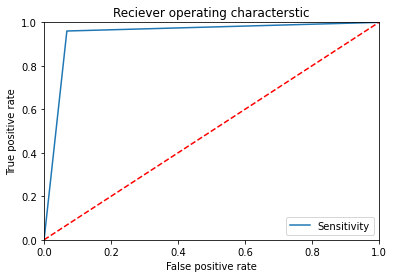

In [ ]:
plt.figure()
plt.plot(fpr,tpr,label='Sensitivity' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Reciever operating characterstic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import seaborn as sns
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

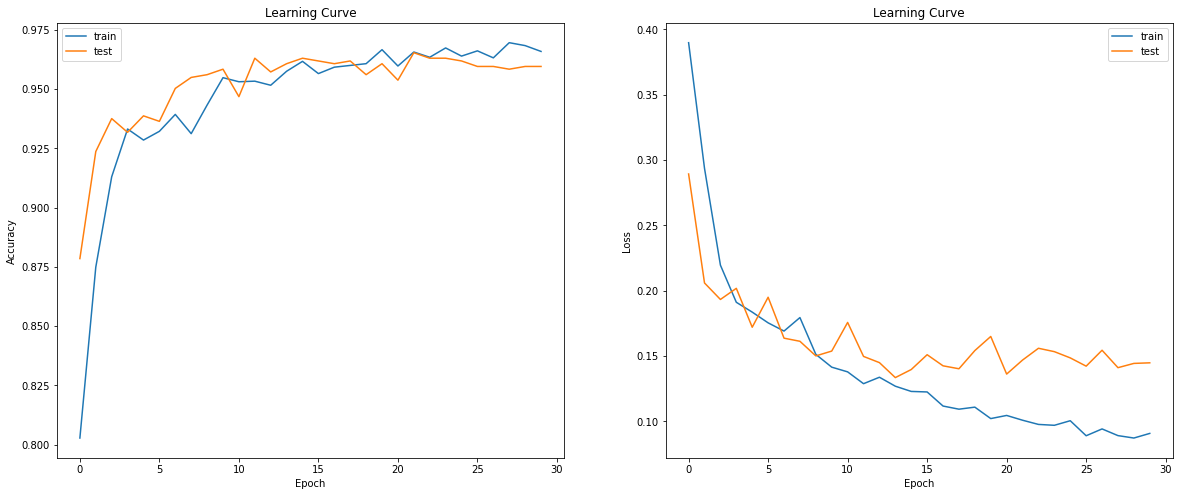

In [ ]:
draw_learning_curve(history4)

#### Model 1 - Confusion matrix

In [ ]:
confusion_mat4 = confusion_matrix(y_true, y_pred)

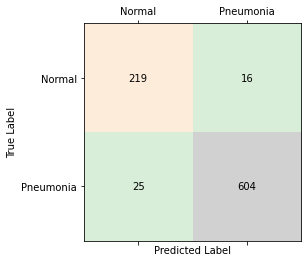

In [ ]:
# Draw Confusion matrix

fig, ax = plt.subplots()

# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
ax.matshow(confusion_mat4, cmap=plt.cm.Accent, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat4[i, j],
               ha='center', va='center')
        
plt.show()

Based on the confusion matrix model 1 table, it can be concluded that in the Pneumonia class there are 604 image data that are predicted correctly and 25 image data that is predicted incorrectly. And the Normal class there are 219 image data predicted correctly and 16 images predicted incorrectly by the model.

# Model 2 with Average Pooling

**Average pooling** is similar to max pooling, but instead of selecting the maximum value in a set of pixels, it selects the average value. The average value is calculated by summing up all the values in the pooling region, and then dividing by the total number of values.

In [ ]:
model5=Sequential()

model5.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))


model5.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model5.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model5.add(Dropout(0.1))

model5.add(GlobalAveragePooling2D())

model5.add(Dense(units=1,activation='sigmoid'))

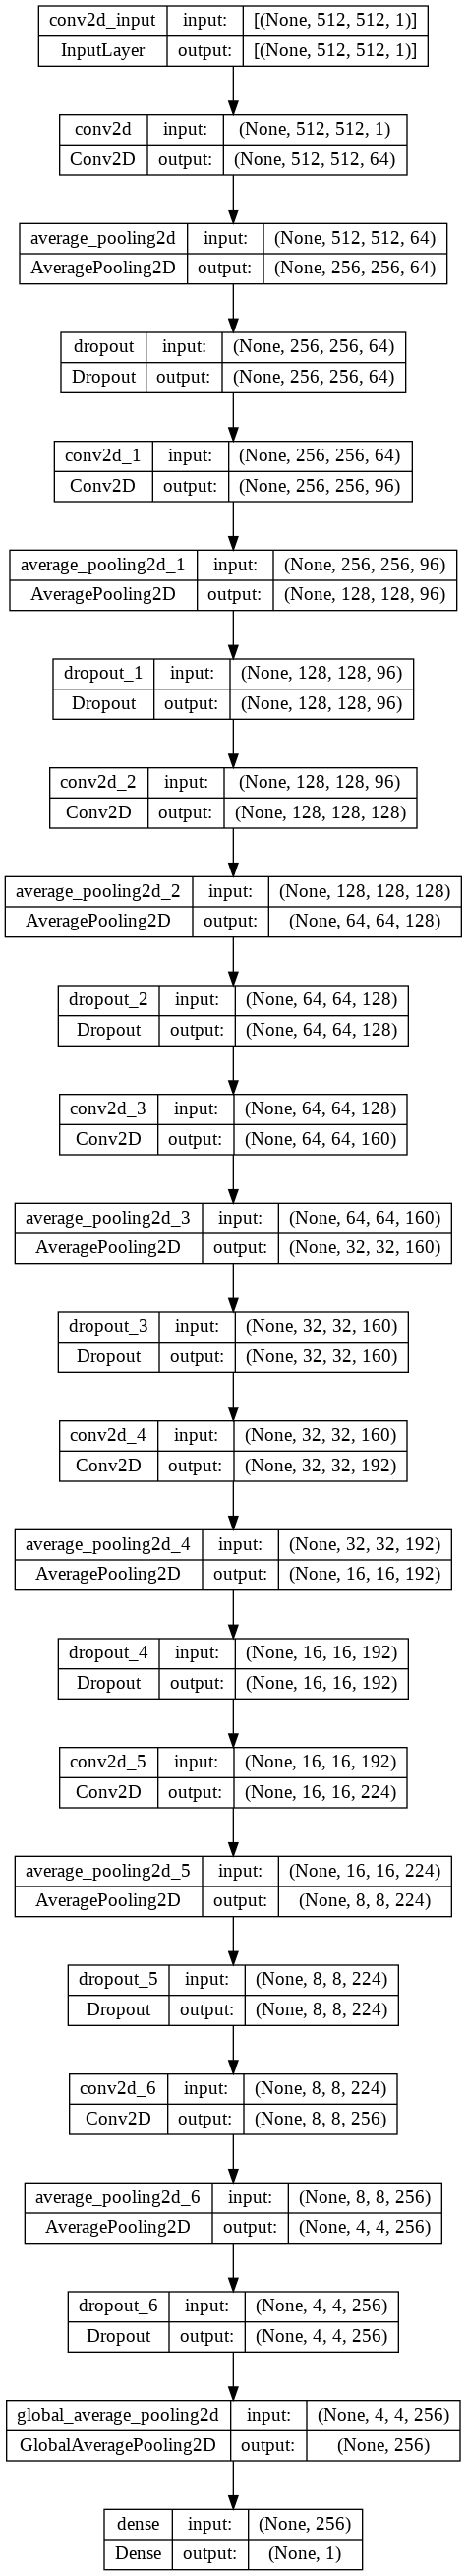

In [ ]:
from tensorflow.keras.utils import plot_model

# See graphical representation of the model
plot_model(model5, show_shapes=True)

In [ ]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='CnnBestModel5.hdf5')

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
history5 = model5.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 2929s 23s/step - loss: 0.6130 - accuracy: 0.7268 - val_loss: 0.5211 - val_accuracy: 0.7083 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 130s 1s/step - loss: 0.5621 - accuracy: 0.7293 - val_loss: 0.6049 - val_accuracy: 0.7373 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 133s 1s/step - loss: 0.4931 - accuracy: 0.7273 - val_loss: 0.6131 - val_accuracy: 0.7373 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 130s 1s/step - loss: 0.4584 - accuracy: 0.7290 - val_loss: 0.5479 - val_accuracy: 0.7373 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0

In [ ]:
# Load saved model
load_model5 = tf.keras.models.load_model(filepath='CnnBestModel5.hdf5')

#### Model 2 - Test accuracy

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
load_model5.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 11s 381ms/step - loss: 0.1469 - accuracy: 0.9456


[0.14689408242702484, 0.9456018805503845]

#### Model 2 - Classification report

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision5 = tf.keras.metrics.Precision()
recall5 = tf.keras.metrics.Recall()

predictions = load_model5.predict(test_gen, steps=test_steps).flatten()
y_pred5=np.where(predictions>0.5,1,0)
y_true5 = test_gen.classes[:len(predictions)]

precision5.update_state(y_true5, y_pred5)
recall5.update_state(y_true5, y_pred5)

27/27 [==============================] - 11s 388ms/step


In [ ]:
print('Precision with test data:', precision5.result().numpy())
print('Recall with base data:', recall5.result().numpy())

Precision with test data: 0.9817881
Recall with base data: 0.9427663


In [ ]:
class_labels5 = list(test_gen.class_indices.keys())
report5 = classification_report(y_true5, y_pred5, target_names=class_labels5)
print(report5)

              precision    recall  f1-score   support

      Normal       0.86      0.95      0.91       235
   Pneumonia       0.98      0.94      0.96       629

    accuracy                           0.95       864
   macro avg       0.92      0.95      0.93       864
weighted avg       0.95      0.95      0.95       864



#### Model 2 - Learning curves

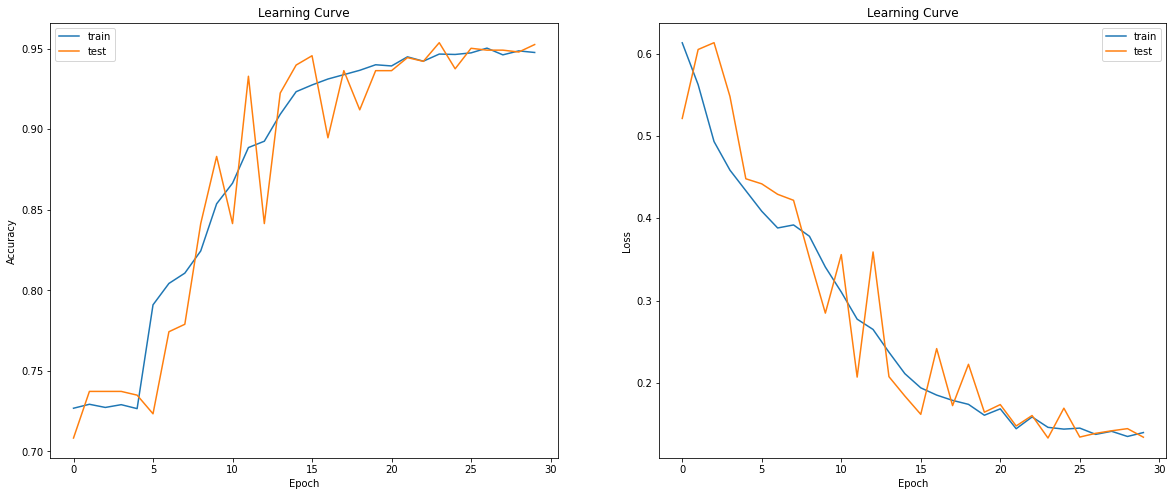

In [ ]:
draw_learning_curve(history5)

#### Model 2 - Confusion matrix

In [ ]:
confusion_mat5 = confusion_matrix(y_true5, y_pred5)

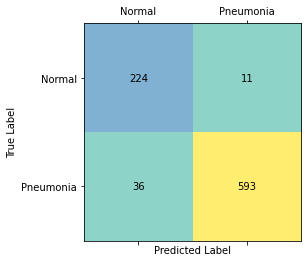

In [ ]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat5, cmap=plt.cm.Set3)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat5[i, j],
               ha='center', va='center')
        
plt.show()

Based on the confusion matrix model 2 table, it can be concluded that in the Pneumonia class there are 593 image data that are predicted correctly and 36 image data that is predicted incorrectly. And the Normal class there are 224 image data predicted correctly and 11 images predicted incorrectly by the model.

# Phase II Implementation

## Mixed (Max+Average) pooling method

**Mixed pooling** is a pooling method that combines different pooling techniques, such as max pooling and average pooling, in a single layer. 

In [ ]:
from keras.layers import Layer
import tensorflow as tf

class MixedPooling2D(tf.keras.layers.Layer):
    def __init__(self, pool_size, strides=2, **kwargs):
        super(MixedPooling2D, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides = strides
        
    def call(self, inputs):
        max_pool = tf.keras.layers.MaxPool2D(self.pool_size,strides=self.strides)(inputs)
        avg_pool = tf.keras.layers.AveragePooling2D(self.pool_size,strides=self.strides)(inputs)
        return max_pool + avg_pool

    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'strides': self.strides,
        }
        base_config = super(MixedPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
model_mix=Sequential()

model_mix.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))

model_mix.add(GlobalAveragePooling2D())

model_mix.add(Dense(units=1,activation='sigmoid'))

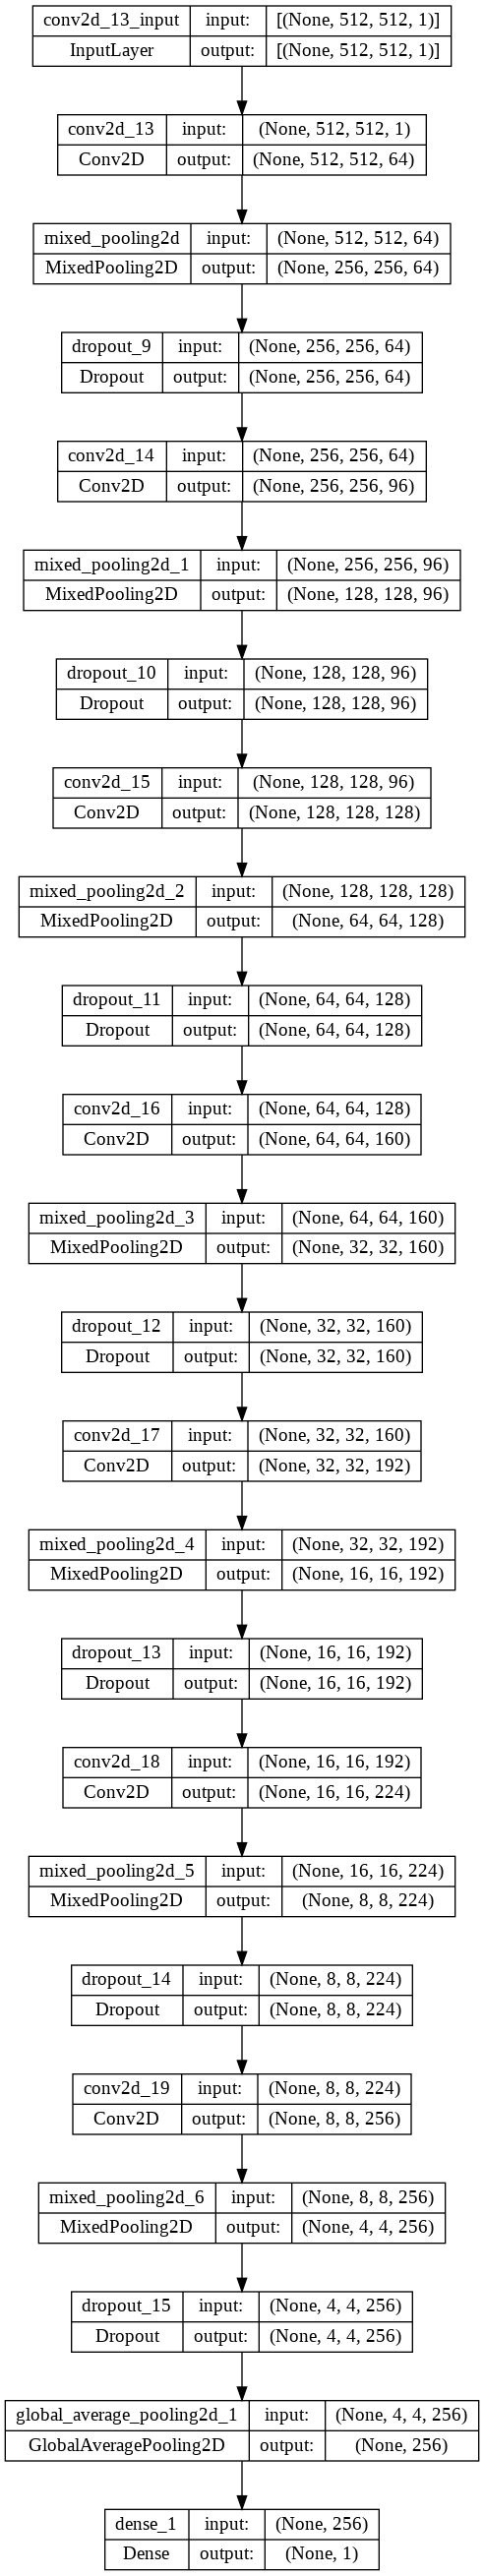

In [ ]:
# See graphical representation of the model
plot_model(model_mix, show_shapes=True)

In [ ]:
model_mix.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='MixModel.hdf5')

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
history_mix = model_mix.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 152s 1s/step - loss: 0.3088 - accuracy: 0.8716 - val_loss: 0.2235 - val_accuracy: 0.9236 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 154s 1s/step - loss: 0.2568 - accuracy: 0.8999 - val_loss: 0.2073 - val_accuracy: 0.9236 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 153s 1s/step - loss: 0.2412 - accuracy: 0.9048 - val_loss: 0.1997 - val_accuracy: 0.9259 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 154s 1s/step - loss: 0.1786 - accuracy: 0.9388 - val_loss: 0.1975 - val_accuracy: 0.9340 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0

In [ ]:
# Loading saved model
load_model_mix = tf.keras.models.load_model(filepath='MixModel.hdf5')

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
model_mix.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 223s 9s/step - loss: 0.1006 - accuracy: 0.9595


[0.10063633322715759, 0.9594907164573669]

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model_mix.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

27/27 [==============================] - 13s 439ms/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

Precision with test data: 0.9852941
Recall with test data: 0.95866454


In [ ]:
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93       235
   Pneumonia       0.99      0.96      0.97       629

    accuracy                           0.96       864
   macro avg       0.94      0.96      0.95       864
weighted avg       0.96      0.96      0.96       864



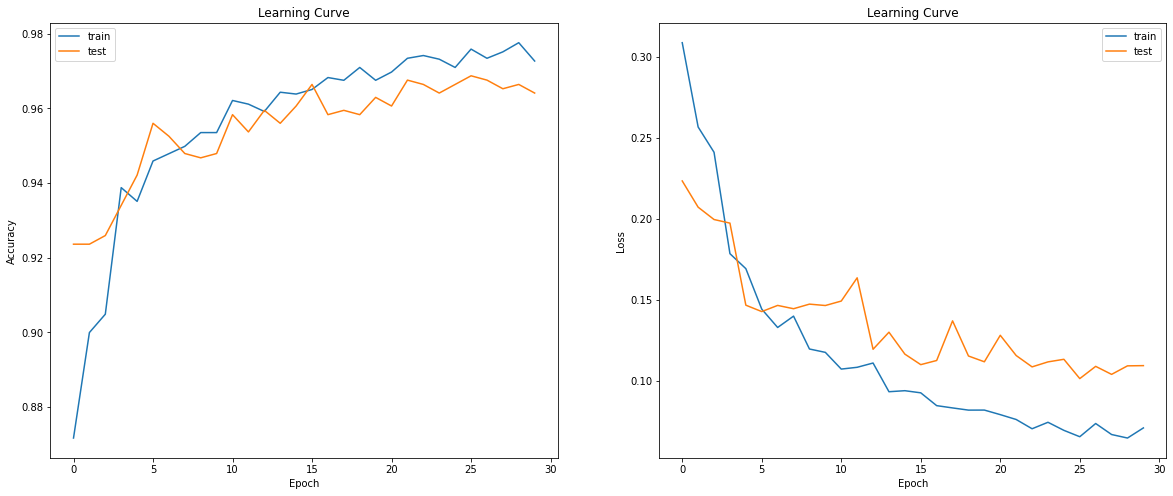

In [ ]:
draw_learning_curve(history_mix)

In [ ]:
confusion_mat_mix = confusion_matrix(y_true, y_pred)

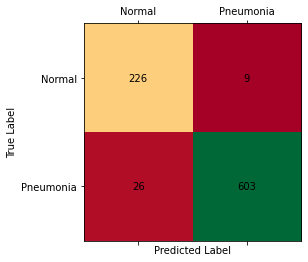

In [ ]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat_mix, cmap=plt.cm.RdYlGn)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat_mix[i, j],
               ha='center', va='center')
        
plt.show()

## Stochastic pooling method

**Stochastic pooling** is a technique used to reduce overfitting in deep learning models. It randomly selects a pooling region from the input feature map instead of using a fixed pooling region, such as a 2x2 region. This can help to make the model more robust to small variations in the input data.

In [ ]:
import numpy as np
from keras.layers import Layer
import keras.backend as K


class StochasticPooling2D(Layer):
    def __init__(self, pool_size=(2, 2), probability=0.5, **kwargs):
        super(StochasticPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.probability = probability

    def call(self, inputs):
        input_shape = K.shape(inputs)
        pool_size = (self.pool_size[0], self.pool_size[1])
        # generate a random tensor with probability of 1's 
        random_tensor = K.random_uniform(shape=input_shape, minval=0, maxval=1, dtype='float32')
        binary_tensor = K.greater(random_tensor, self.probability)
        binary_tensor = K.cast(binary_tensor, dtype='float32')
        
        # perform pooling on binary tensor
        output = K.tf.nn.pool(binary_tensor * inputs, window_shape=pool_size, pooling_type='AVG', padding='SAME', strides=pool_size)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] // self.pool_size[0], input_shape[2] // self.pool_size[1], input_shape[3])

    def get_config(self):
        config = {'pool_size': self.pool_size, 'probability': self.probability}
        base_config = super(StochasticPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    


In [ ]:
model_stoch = keras.Sequential()

model_stoch.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))


model_stoch.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_stoch.add(StochasticPooling2D(pool_size=(2, 2)))
model_stoch.add(Dropout(0.1))

model_stoch.add(GlobalAveragePooling2D())

model_stoch.add(Dense(units=1,activation='sigmoid'))

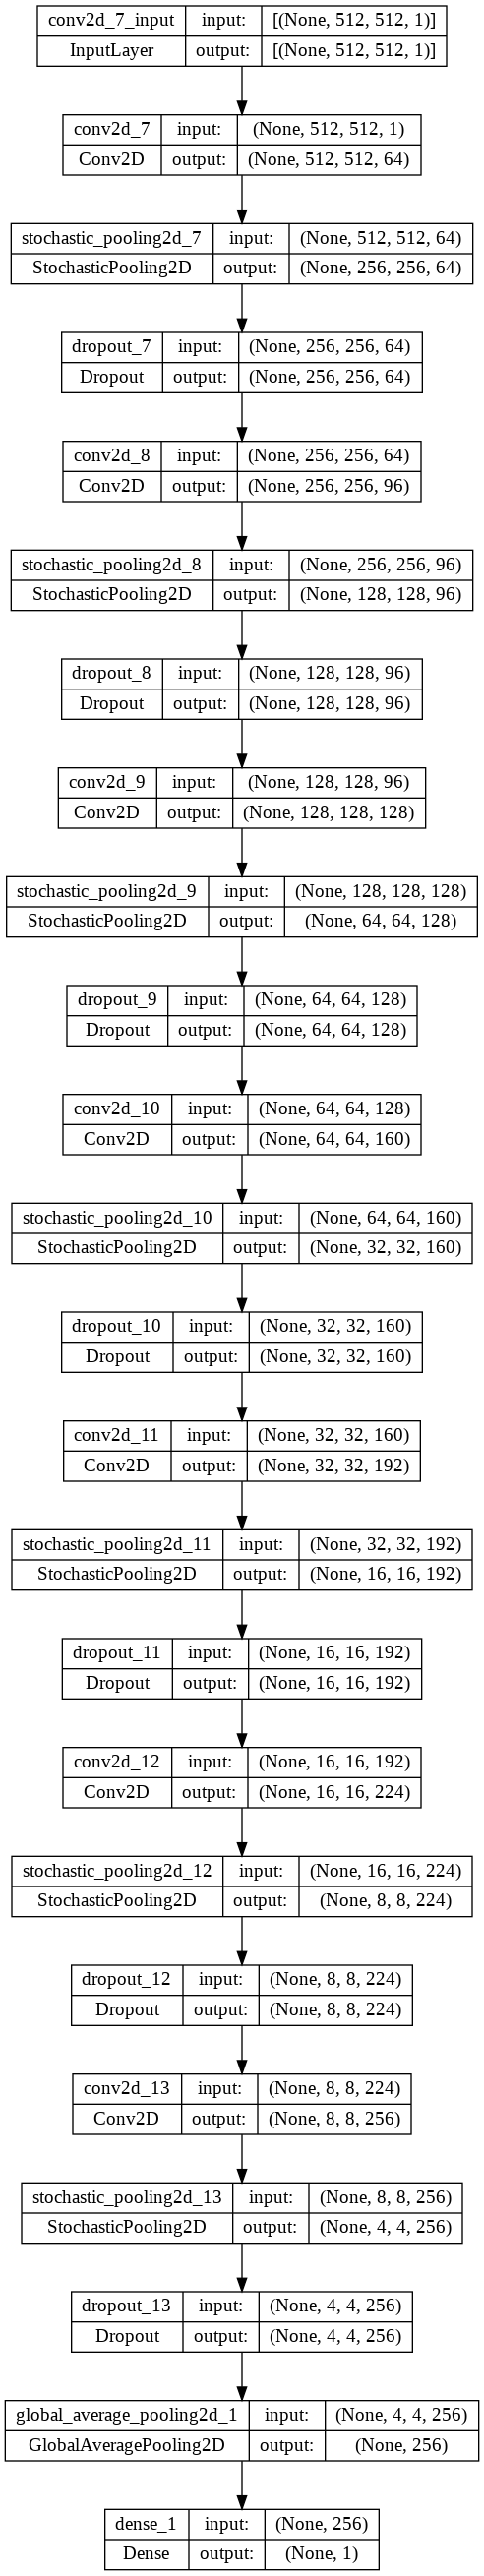

In [ ]:
# See graphical representation of the model
plot_model(model_stoch, show_shapes=True)

In [ ]:
model_stoch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='StochModel.hdf5')

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
history_stoch = model_stoch.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 114s 882ms/step - loss: 0.5961 - accuracy: 0.7276 - val_loss: 0.5769 - val_accuracy: 0.7373 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 112s 876ms/step - loss: 0.5709 - accuracy: 0.7246 - val_loss: 0.5086 - val_accuracy: 0.7211 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 112s 877ms/step - loss: 0.4958 - accuracy: 0.7480 - val_loss: 0.4883 - val_accuracy: 0.7569 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 112s 875ms/step - loss: 0.4201 - accuracy: 0.8033 - val_loss: 0.4615 - val_accuracy: 0.7697 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
model_stoch.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 320s 12s/step - loss: 0.1982 - accuracy: 0.9178


[0.19820354878902435, 0.9178240895271301]

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model_stoch.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)


27/27 [==============================] - 10s 352ms/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())


Precision with test data: 0.96416384
Recall with test data: 0.8982512


In [ ]:
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

      Normal       0.77      0.91      0.83       235
   Pneumonia       0.96      0.90      0.93       629

    accuracy                           0.90       864
   macro avg       0.87      0.90      0.88       864
weighted avg       0.91      0.90      0.90       864



In [ ]:
# draw_learning_curve(history_stoch):

In [ ]:
confusion_matstoch = confusion_matrix(y_true, y_pred)

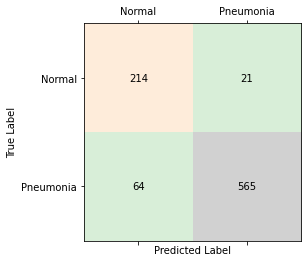

In [ ]:
# Draw Confusion matrix

fig, ax = plt.subplots()

# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
ax.matshow(confusion_matstoch, cmap=plt.cm.Accent, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_matstoch[i, j],
               ha='center', va='center')
        
plt.show()

# 

## L2 Norm pooling method

**L2 norm pooling** is a method used to reduce the dimensionality of a feature vector by computing the square root of the sum of squares of the elements in the vector. This method is similar to the more commonly used max pooling method, but instead of taking the maximum value in a pooling window, it takes the square root of the sum of squares. This can be useful in some applications where preservation of the overall vector magnitude is important.

In [ ]:
from keras.layers import Layer
import tensorflow as tf

class L2NormPooling2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(L2NormPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size

    def build(self, input_shape):
        super(L2NormPooling2D, self).build(input_shape)

    def call(self, x):
        return tf.math.l2_normalize(tf.nn.max_pool2d(x, self.pool_size, strides=self.pool_size, padding='VALID'), axis=(1,2))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


    def get_config(self):
        config = {
            'pool_size': self.pool_size,
        }
        base_config = super(L2NormPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
model_lp = keras.Sequential()

model_lp.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))


model_lp.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_lp.add(L2NormPooling2D())
model_lp.add(Dropout(0.1))

model_lp.add(GlobalAveragePooling2D())

model_lp.add(Dense(units=1,activation='sigmoid'))

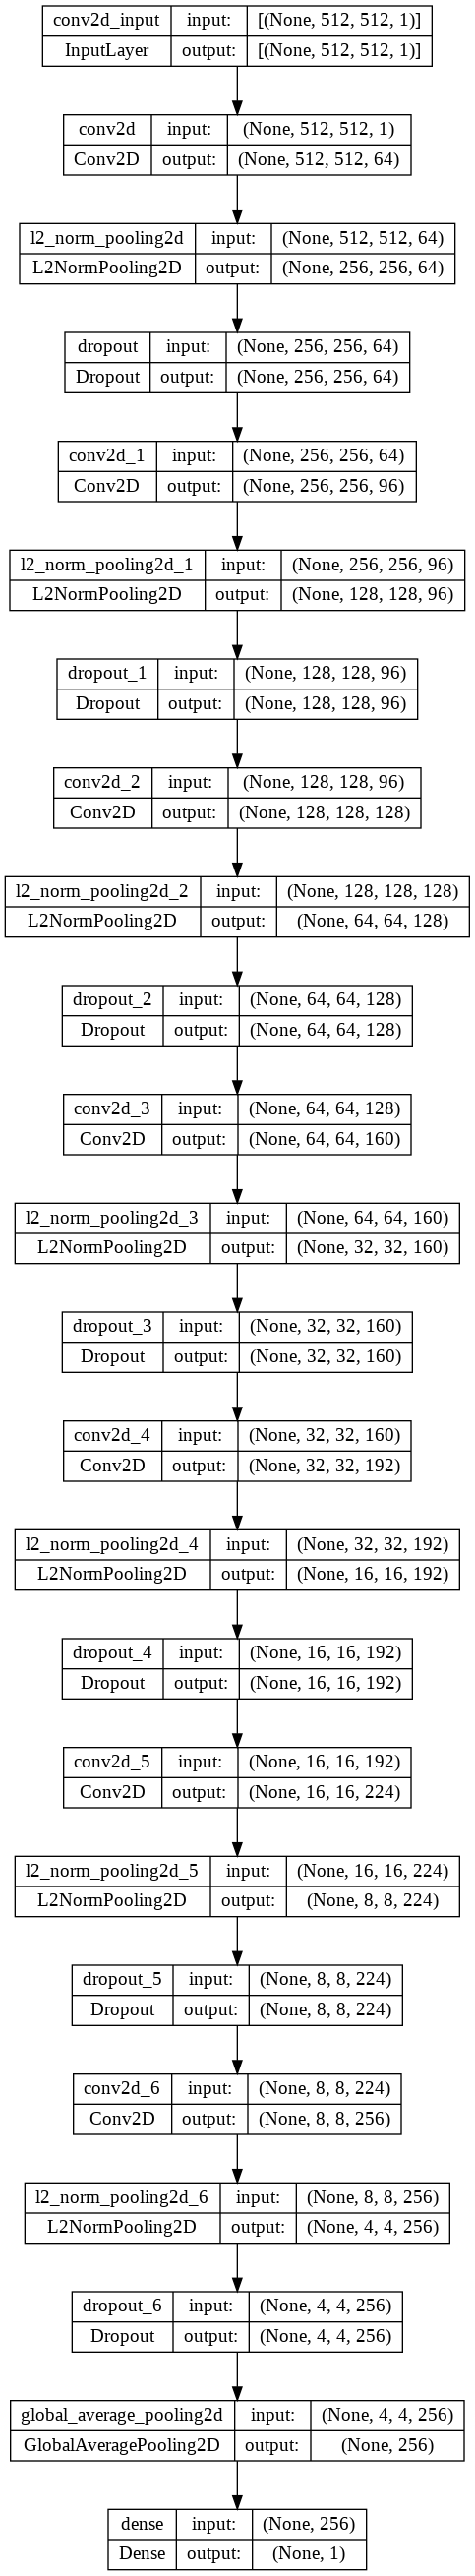

In [ ]:
# See graphical representation of the model
plot_model(model_lp, show_shapes=True)

In [ ]:
model_lp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='ModelL2Pooling.hdf5')


In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE


In [ ]:
historyL2 = model_lp.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 3745s 29s/step - loss: 0.4399 - accuracy: 0.7748 - val_loss: 0.4446 - val_accuracy: 0.7373 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 110s 856ms/step - loss: 0.3404 - accuracy: 0.8559 - val_loss: 0.2840 - val_accuracy: 0.8900 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 110s 856ms/step - loss: 0.3043 - accuracy: 0.8763 - val_loss: 0.2599 - val_accuracy: 0.9028 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 110s 852ms/step - loss: 0.2762 - accuracy: 0.8898 - val_loss: 0.2373 - val_accuracy: 0.9155 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning 

In [ ]:
from keras.utils import CustomObjectScope

with CustomObjectScope({'L2NormPooling2D': L2NormPooling2D}):
    model = load_model('ModelL2Pooling.hdf5')

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
model.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 284s 10s/step - loss: 0.3058 - accuracy: 0.8565


[0.30577757954597473, 0.8564814925193787]

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

27/27 [==============================] - 276s 10s/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

Precision with test data: 0.9650092
Recall with test data: 0.8330684


In [ ]:
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.67      0.92      0.78       235
   Pneumonia       0.97      0.83      0.89       629

    accuracy                           0.86       864
   macro avg       0.82      0.88      0.84       864
weighted avg       0.89      0.86      0.86       864



In [ ]:
# draw_learning_curve(historyL2)

In [ ]:
confusion_mat4 = confusion_matrix(y_true, y_pred)

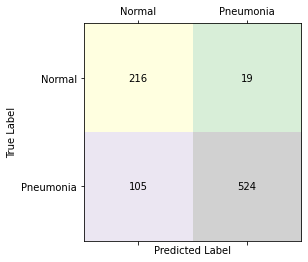

In [ ]:
# Draw Confusion matrix

fig, ax = plt.subplots()

# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
ax.matshow(confusion_mat4, cmap=plt.cm.Accent, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat4[i, j],
               ha='center', va='center')
        
plt.show()

## Runpool pooling method

**RunPool** is similar to max pooling, where the maximum value in a set of pixels is selected as the representative value for that set, but it also considers the second highest value. This allows for more robust feature extraction, as it provides information about both the most prominent feature in an image and the second most prominent feature. It has been used in various image processing tasks, such as object detection and semantic segmentation.

In [ ]:
class RunPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super(RunPool2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.keras.layers.MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)

    def build(self, input_shape):
        super(RunPool2D, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'strides':self.strides,
            'padding':self.padding
            
        }
        base_config = super(RunPool2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
model_Runpool=Sequential()

model_Runpool.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(512,512,1)))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))

model_Runpool.add(GlobalAveragePooling2D())

model_Runpool.add(Dense(units=1,activation='sigmoid'))

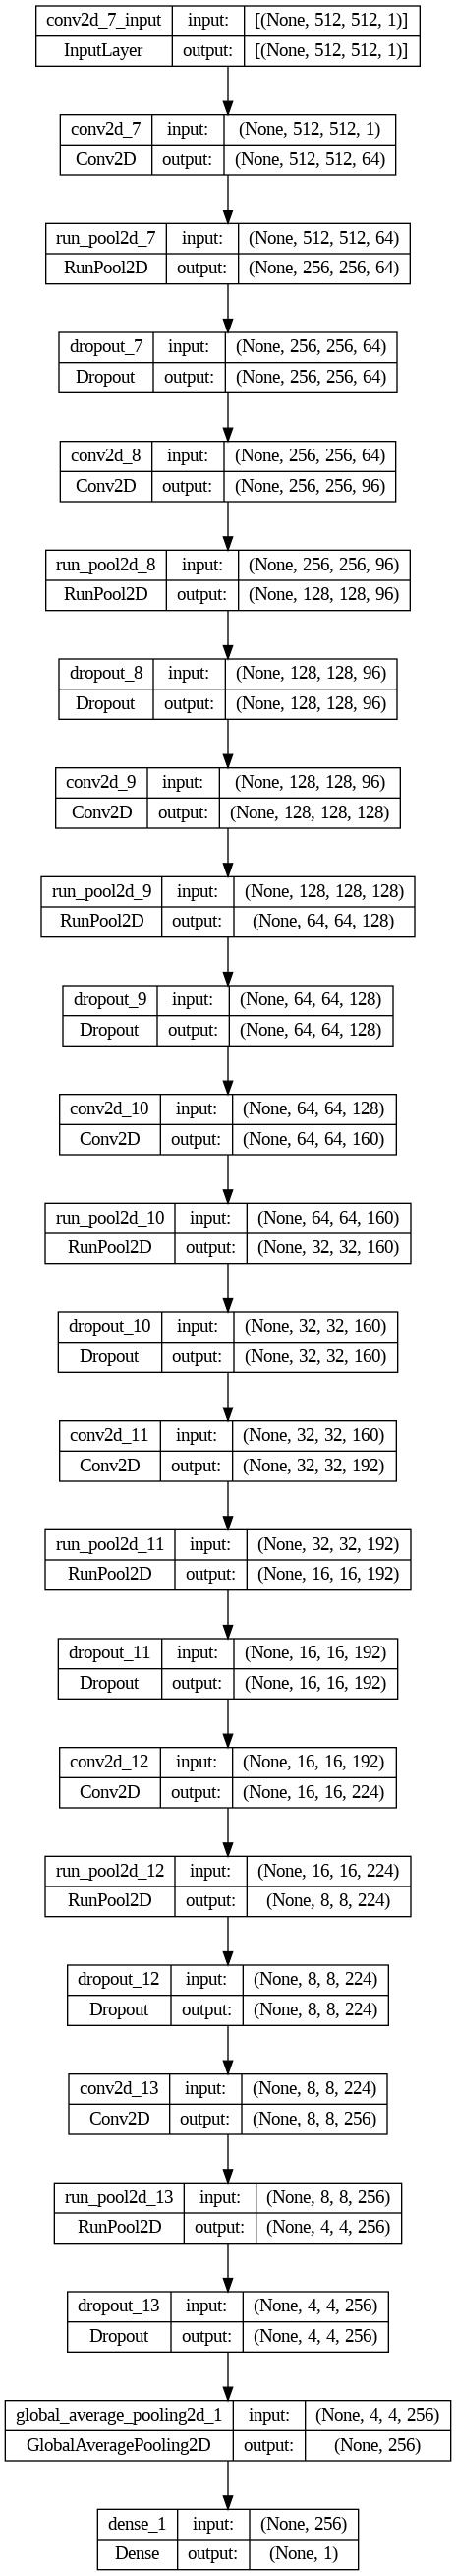

In [ ]:
# See graphical representation of the model
plot_model(model_Runpool, show_shapes=True)

In [ ]:
model_Runpool.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='Model_Runpool.hdf5')

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
historyRunpool = model_Runpool.fit(train_gen,                    
                    epochs=30,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    # shuffle=False,

                    callbacks = [lr_scheduler, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
128/128 [==============================] - 1798s 14s/step - loss: 0.5212 - accuracy: 0.7244 - val_loss: 0.3610 - val_accuracy: 0.7373 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
128/128 [==============================] - 115s 893ms/step - loss: 0.3935 - accuracy: 0.7885 - val_loss: 0.3671 - val_accuracy: 0.8762 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
128/128 [==============================] - 115s 892ms/step - loss: 0.3358 - accuracy: 0.8552 - val_loss: 0.2559 - val_accuracy: 0.9097 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
128/128 [==============================] - 115s 894ms/step - loss: 0.2759 - accuracy: 0.8864 - val_loss: 0.2271 - val_accuracy: 0.9213 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning 

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
model_Runpool.evaluate(test_gen, steps=test_steps)

27/27 [==============================] - 304s 12s/step - loss: 0.1120 - accuracy: 0.9595


[0.11203212291002274, 0.9594907164573669]

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model_Runpool.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

27/27 [==============================] - 9s 339ms/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

Precision with test data: 0.9966555
Recall with test data: 0.94753575


In [ ]:
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93       235
   Pneumonia       1.00      0.95      0.97       629

    accuracy                           0.96       864
   macro avg       0.94      0.97      0.95       864
weighted avg       0.96      0.96      0.96       864



In [ ]:
import seaborn as sns
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()


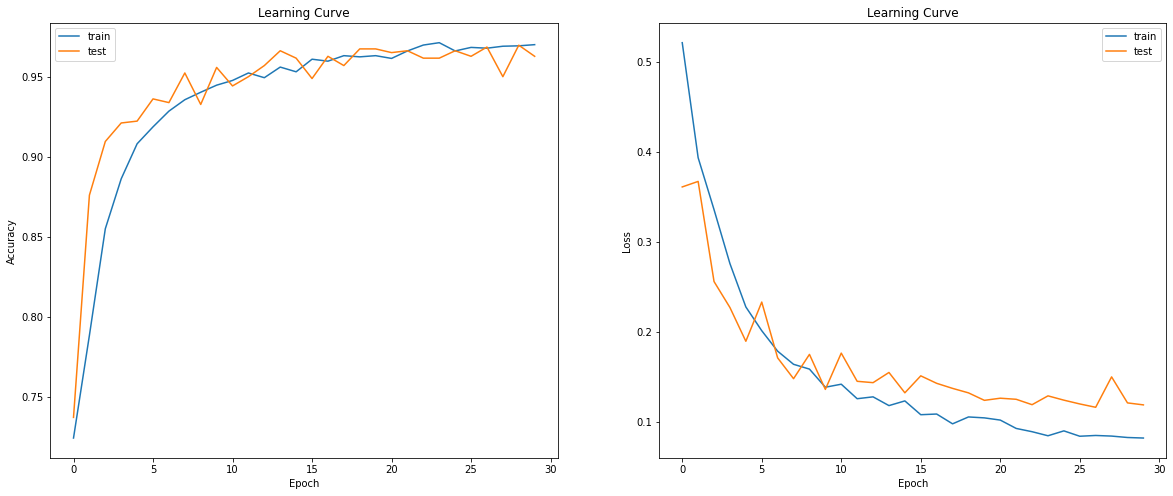

In [ ]:
draw_learning_curve(historyRunpool)

## **Summary**

|Model | Train Accuracy | Test Accuracy | Presicion | Recall |
|:------|:---------------|:--------------|:----------|:--------
|Max Pooling|97.41|	96.02|	95.75|	95.25|
|Avg Pooling|	98.17|	94.27|	94.76|	94.56|
|Mixed Pooling|	98.52|	95.86|	97.27|	95.95|
|Stochastic pooling|	96.41|	89.82|	94.19|	91.78|
|L2 Norm pooling|	96.50|	83.30|	87.61|	85.65|
|Runpool pooling|	99.66|	94.75|	97.02|	95.95|


**Conclusion:** Due to its simple implementation and sparse representation, max pooling has been the focus point. However, its main drawback is that it is deterministic. Randomness has proved to be a valuable resource for various pooling mechanisms, including “hybrid” max average,  Stochastic pooling etc. The stochasticity of these schemes introduces unpredictability in the selection of activation regions, which significantly reduces overfitting and improves model generalization ability. In addition, the pooling method reduces the number of parameters required for training due to its feature reduction characteristics. This benefits deep architecture in terms of computational costs. After performing analysis of the performance of the pooling operation and classification task, it can be concluded that the performance of the pooling operation is highly dependent on the network architecture and activation functions. Therefore, it is not unfair to conclude that the choice of pooling operation is resonable, as it helps us in understanding the pooling techniques and the variables that affect the performance of the pooling operation
<br/>

##### From the above observation we can conclude that Max, Average and Runpool pooling methods are good for the Pneumonia dataset however it's not always neccessarily shows that it will work good for other dataset too, as performance of the pooling operation is highly dependent on the network architecture and activation functions.

#######################################################################################################################

# Applying best pooling method for Brain Tumor dataset

## Brain Tumor

A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.
Application of automated classification techniques using Machine Learning(ML) and Artificial Intelligence(AI)has consistently shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms using ConvolutionNeural Network (CNN), Artificial Neural Network (ANN), and TransferLearning (TL) would be helpful to doctors all around the world.

Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor. Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.

### About Dataset: 

This dataset consists of the images of brain x-rays of patient diagnosed of brain tumor. There are total of 4600 images consisting of Brain Tumor (2513) & 
Healthy images (2087). Size of dataset 107MB.

In [ ]:
# Import necessary libraries

import os
import cv2
import numpy as np
from google.colab import files
from google.colab import drive

import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras import initializers
from keras import optimizers
from keras.layers import *
from keras import layers
from keras.layers import Conv2D, MaxPooling2D,Activation
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

import tensorflow
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

np.random.seed(22)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.environ['PROJ_CONFIG_DIR'] = "/content/gdrive/My Drive/Project"

In [ ]:
%cd /content/drive/MyDrive/Project/

/content/drive/MyDrive/Project


### Download dataset from kaggle

In [ ]:
# !ls -lha kaggle.json

In [ ]:
# !pip install -q kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 /root/.kaggle/kaggle.json
# !pwd

/content/drive/MyDrive/Project


In [ ]:
# !kaggle datasets download -d preetviradiya/brian-tumor-dataset

 90% 97.0M/107M [00:01<00:00, 73.9MB/s]
100% 107M/107M [00:01<00:00, 67.4MB/s] 


In [ ]:
# !unzip /content/drive/MyDrive/Project/brian-tumor-dataset.zip -d /content/drive/MyDrive/Project/

In [ ]:
os.listdir('/content/drive/MyDrive/Project/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

### Data Preprocessing

In [ ]:
img_size=150

def read_data(data_paths):
    for data_path in data_paths:
        labels=['Brain Tumor','Healthy']
        images=[]
        for label in labels:
            curr_path=data_path+label
            for img in os.listdir(curr_path):
                if('DS' not in img):
                    image_path=os.path.join(curr_path,img)
                    image=cv2.resize(cv2.imread(image_path), (img_size,img_size))
                    if image is not None:
                        images.append([image,label])
                        
        images=np.asarray(images)
        return images

In [ ]:
data='/content/drive/MyDrive/Project/Brain Tumor Data Set/Brain Tumor Data Set/'

data=read_data([data])

<ipython-input-6-2843ca710c71>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images=np.asarray(images)


In [ ]:
for i in range(10):
    np.random.shuffle(data)

In [ ]:
import pandas as pd
data_f=pd.DataFrame(data,columns=['image','label'])

In [ ]:
data_f['label'].head()

0    Brain Tumor
1    Brain Tumor
2        Healthy
3    Brain Tumor
4        Healthy
Name: label, dtype: object

### Data Visualization

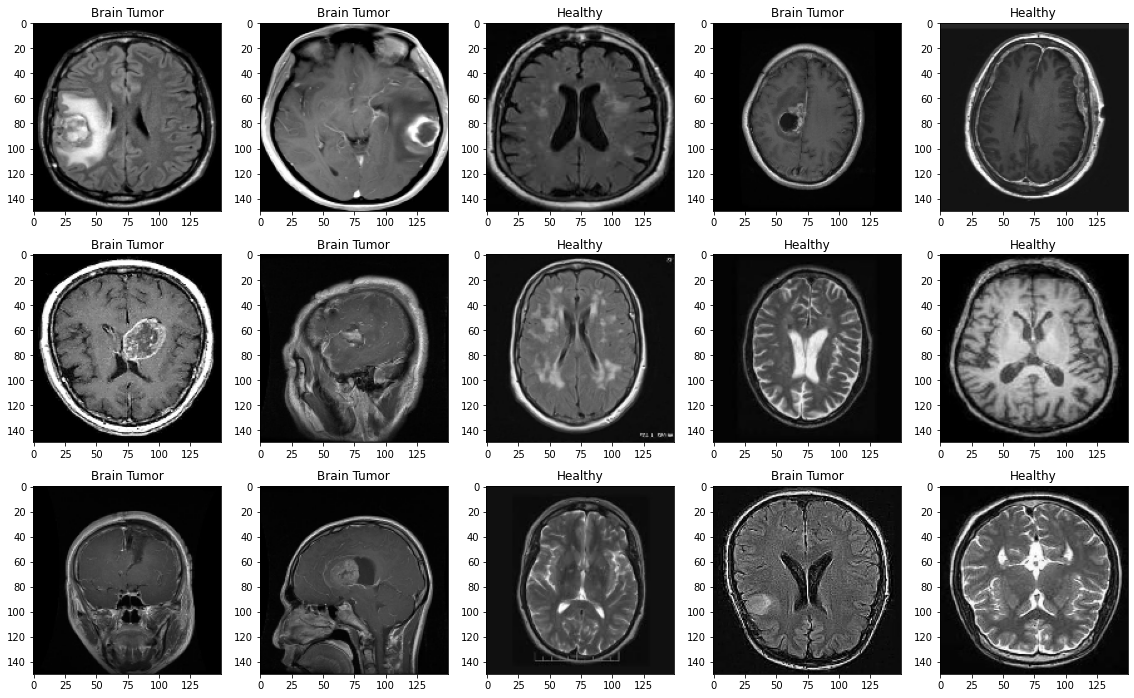

In [ ]:
def show_image():
    fig=plt.figure(figsize=(16,16))
    for idx in range(15):
        plt.subplot(5,5,idx+1)
        plt.imshow(data_f.iloc[idx]['image'])
        plt.title("{}".format(data_f.iloc[idx]['label']))
        plt.tight_layout()

show_image()

### Data Augmentation

In [ ]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99))

In [ ]:
train = gen.flow_from_directory("/content/drive/MyDrive/Project/Brain Tumor Data Set/Brain Tumor Data Set/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               subset = "training",
                               seed = 123,
                               )

Found 3681 images belonging to 2 classes.


In [ ]:
val = gen.flow_from_directory("/content/drive/MyDrive/Project/Brain Tumor Data Set/Brain Tumor Data Set/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 919 images belonging to 2 classes.


In [ ]:
classes

{'Brain Tumor': 0, 'Healthy': 1}

# Custom model with Max pooling

In [ ]:
model_tumor1=Sequential()

model_tumor1.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(150,150,3)))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))


model_tumor1.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_tumor1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_tumor1.add(Dropout(0.1))

model_tumor1.add(GlobalAveragePooling2D())

model_tumor1.add(Dense(units=1,activation='sigmoid'))

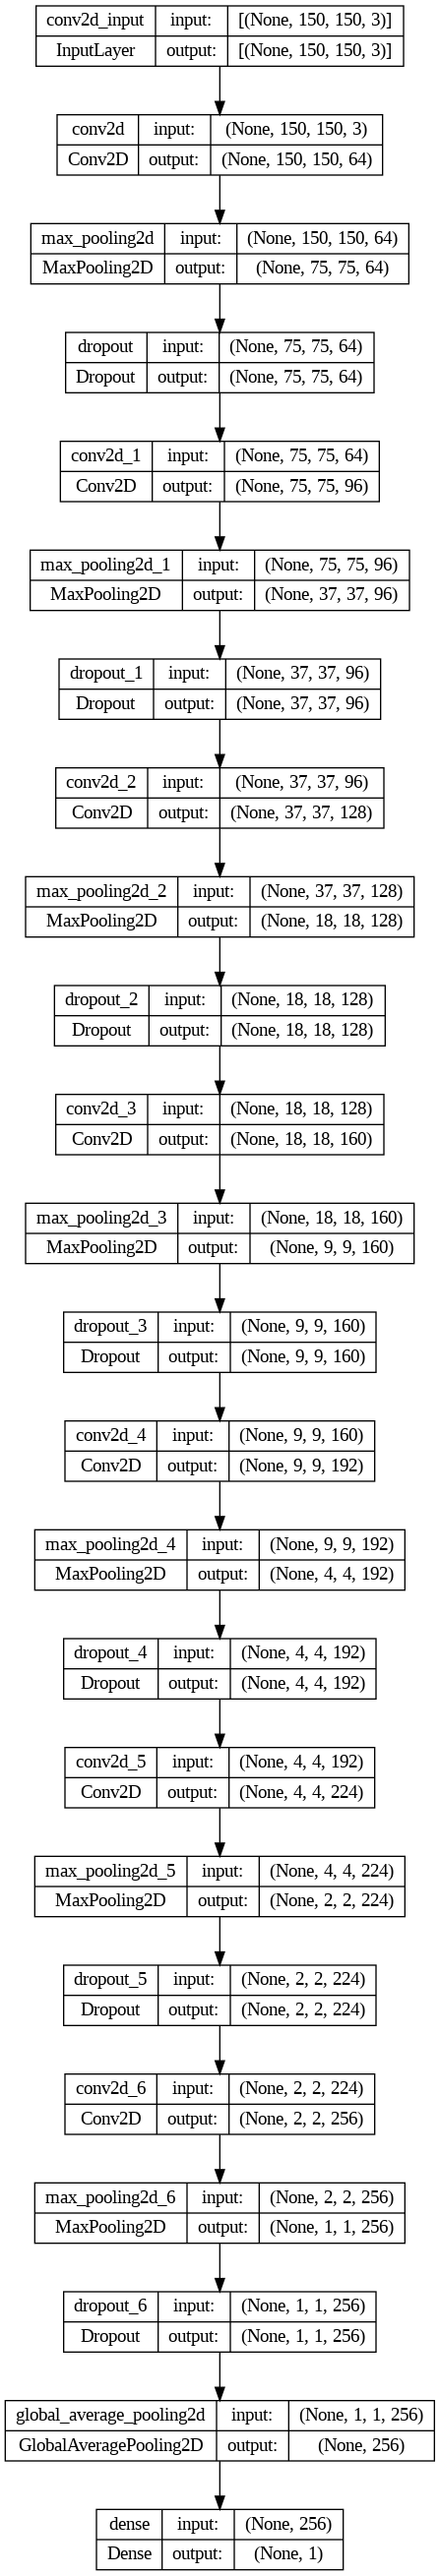

In [ ]:
# See graphical representation of the model
plot_model(model_tumor1, show_shapes=True)

In [ ]:
model_tumor1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_tumor1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 96)        55392     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 96)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 96)        0

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='Model_tumor1.hdf5')

In [ ]:
history_tumor1 = model_tumor1.fit(train,                    
                    epochs=30,                    
                    # steps_per_epoch=train_steps,                    
                    validation_data=val,
                    # validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint],verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
15/15 [==============================] - 437s 29s/step - loss: 0.6922 - accuracy: 0.5542 - val_loss: 0.6493 - val_accuracy: 0.5626 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
15/15 [==============================] - 430s 29s/step - loss: 0.6621 - accuracy: 0.6088 - val_loss: 0.5887 - val_accuracy: 0.7106 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
15/15 [==============================] - 429s 28s/step - loss: 0.6027 - accuracy: 0.6786 - val_loss: 0.6064 - val_accuracy: 0.6681 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
15/15 [==============================] - 429s 28s/step - loss: 0.5464 - accuracy: 0.7403 - val_loss: 0.5593 - val_accuracy: 0.7106 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00067

# Custom model with Runpool

In [ ]:
class RunPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super(RunPool2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.keras.layers.MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)

    def build(self, input_shape):
        super(RunPool2D, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'strides':self.strides,
            'padding':self.padding
            
        }
        base_config = super(RunPool2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
model_Runpool=Sequential()

model_Runpool.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(150,150,3)))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))


model_Runpool.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_Runpool.add(RunPool2D())
model_Runpool.add(Dropout(0.1))

model_Runpool.add(GlobalAveragePooling2D())

model_Runpool.add(Dense(units=1,activation='sigmoid'))

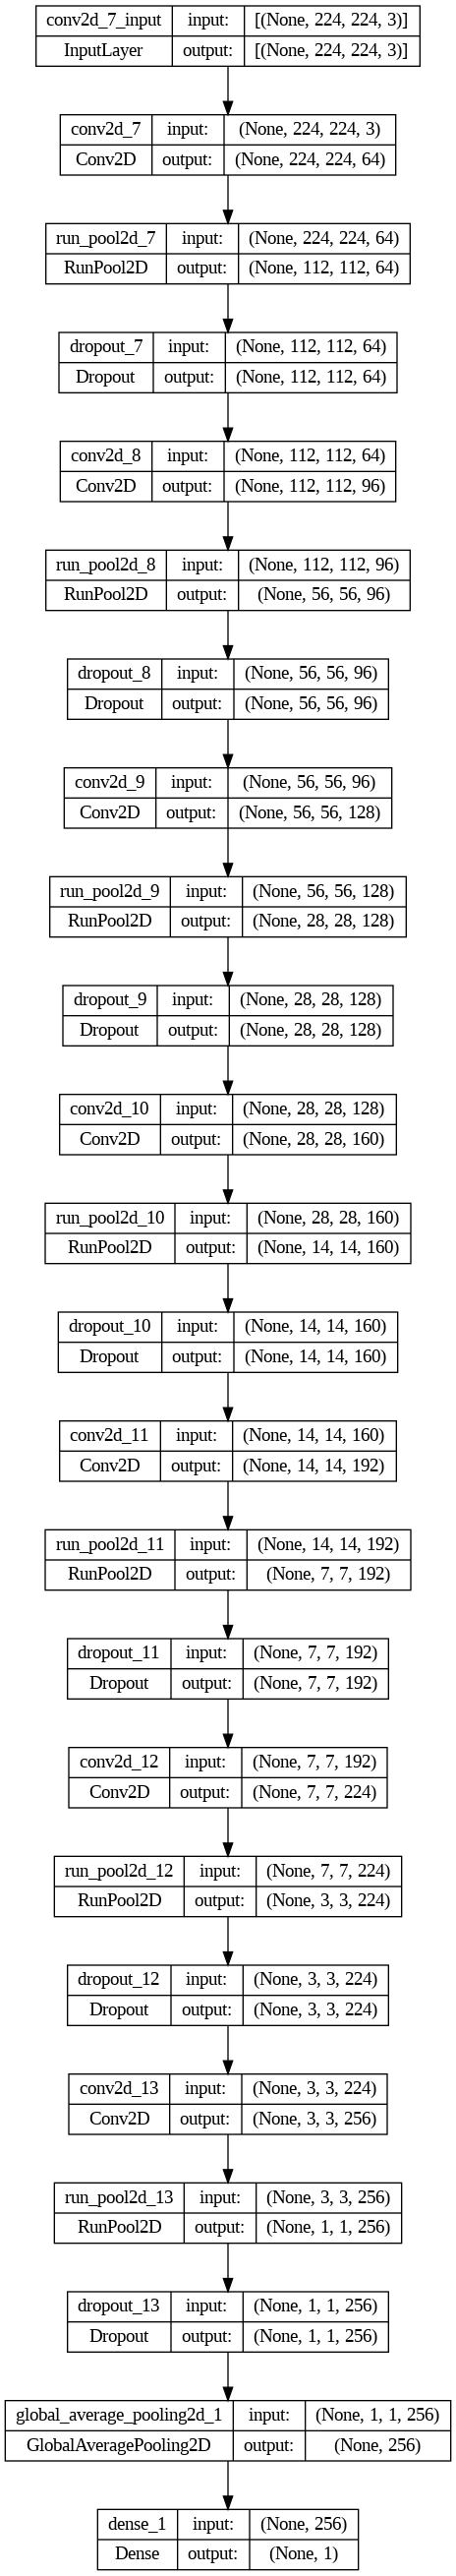

In [ ]:
# See graphical representation of the model
plot_model(model_Runpool, show_shapes=True)

In [ ]:
model_Runpool.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='Runpool.hdf5')

In [ ]:
history_tumor2 = model_Runpool.fit(train,                    
                    epochs=30,                    
                    # steps_per_epoch=train_steps,                    
                    validation_data=val,
                    # validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint],verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
15/15 [==============================] - 1584s 104s/step - loss: 0.6897 - accuracy: 0.5365 - val_loss: 0.6390 - val_accuracy: 0.5941 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
15/15 [==============================] - 388s 26s/step - loss: 0.6593 - accuracy: 0.6020 - val_loss: 0.6194 - val_accuracy: 0.6703 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
15/15 [==============================] - 384s 26s/step - loss: 0.6012 - accuracy: 0.6968 - val_loss: 0.6087 - val_accuracy: 0.6866 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
15/15 [==============================] - 385s 26s/step - loss: 0.5276 - accuracy: 0.7509 - val_loss: 0.5049 - val_accuracy: 0.7715 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000

# Mixed Pooling

In [ ]:
from keras.layers import Layer
import tensorflow as tf

class MixedPooling2D(tf.keras.layers.Layer):
    def __init__(self, pool_size, strides=2, **kwargs):
        super(MixedPooling2D, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides = strides
        
    def call(self, inputs):
        max_pool = tf.keras.layers.MaxPool2D(self.pool_size,strides=self.strides)(inputs)
        avg_pool = tf.keras.layers.AveragePooling2D(self.pool_size,strides=self.strides)(inputs)
        return max_pool + avg_pool

    def get_config(self):
        config = {
            'pool_size': self.pool_size,
            'strides': self.strides,
        }
        base_config = super(MixedPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
model_mix=Sequential()

model_mix.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(150,150,3)))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=96,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=160,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=224,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))


model_mix.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model_mix.add(MixedPooling2D(pool_size=(2, 2)))
model_mix.add(Dropout(0.1))

model_mix.add(GlobalAveragePooling2D())

model_mix.add(Dense(units=1,activation='sigmoid'))

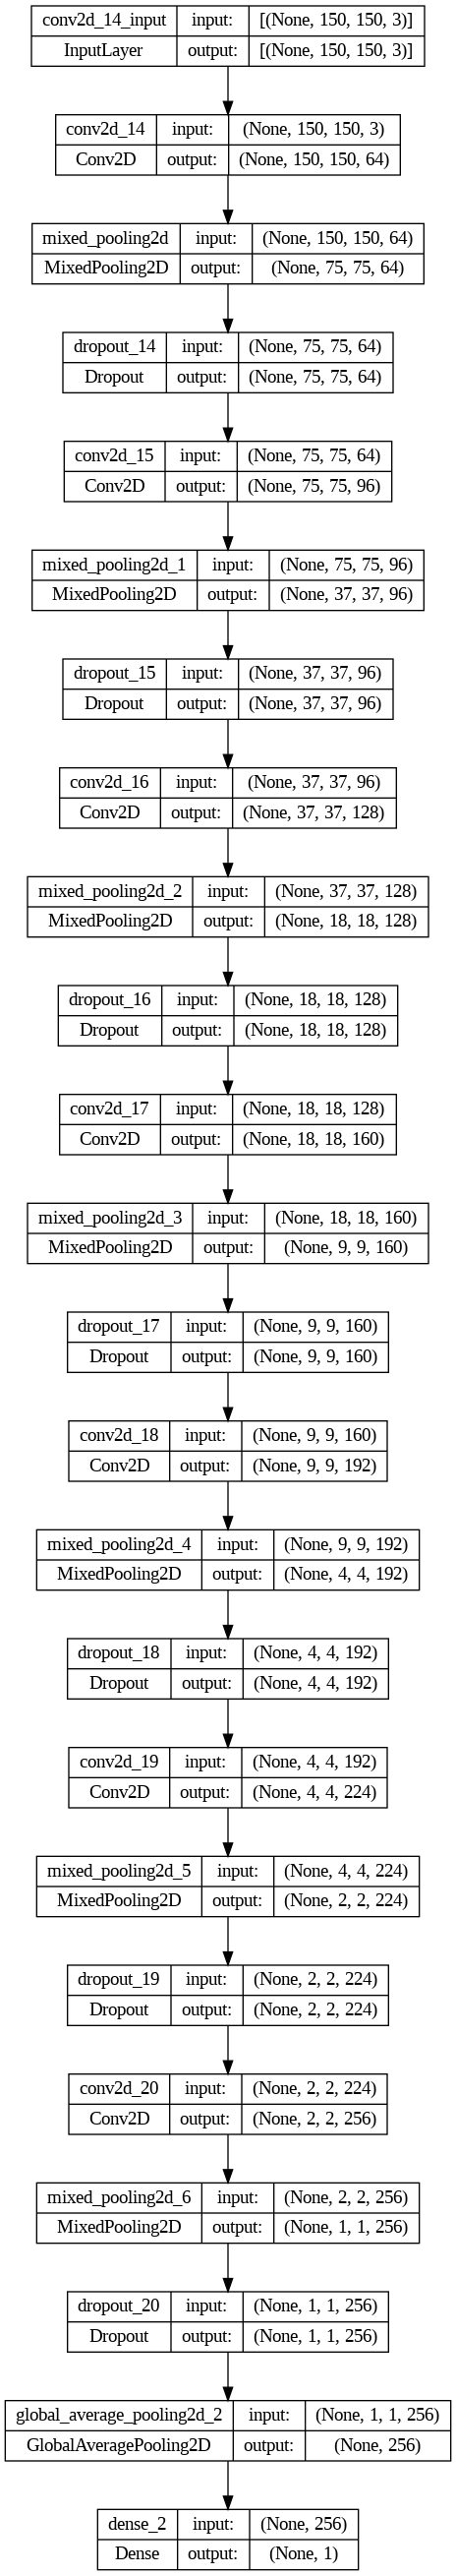

In [ ]:
# See graphical representation of the model
plot_model(model_mix, show_shapes=True)

In [ ]:
model_mix.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def lr_decay(epoch):
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
model_checkpoint = ModelCheckpoint(filepath='MixModel_Tumor.hdf5')

In [ ]:
history_mix = model_mix.fit(train,                    
                    epochs=30,                    
                    # steps_per_epoch=train_steps,                    
                    validation_data=val,
                    # validation_steps=val_steps,                    
                    # shuffle=False,
                    callbacks = [lr_scheduler, model_checkpoint],verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
15/15 [==============================] - 421s 29s/step - loss: 2.8504 - accuracy: 0.5265 - val_loss: 0.6778 - val_accuracy: 0.6540 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/30
15/15 [==============================] - 417s 27s/step - loss: 0.6780 - accuracy: 0.5729 - val_loss: 0.6502 - val_accuracy: 0.5876 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/30
15/15 [==============================] - 417s 28s/step - loss: 0.6548 - accuracy: 0.5955 - val_loss: 0.5932 - val_accuracy: 0.6997 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/30
15/15 [==============================] - 415s 28s/step - loss: 0.6199 - accuracy: 0.6659 - val_loss: 0.6095 - val_accuracy: 0.6670 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00067

#### Summary: Performed max pooling, Runpool pooling and Mixed pooling methods on Brain Tumor dataset, results shows good accuracy achieved for all pooling methods.
<br/>

 
|Model | Train Accuracy | Val. Accuracy | 
|:------|:---------------|:-------------|
|Max Pooling | 99.10|	98.37|	
|Runpool pooling|	98.89|	98.69|
|Mixed pooling|	95.95|	95.76|

#####################################################################################################################

## Applying Transfer Learning to Pneumonia dataset for further Study

### **What Is Transfer Learning?**

The reuse of a pre-trained model on a new problem is known as transfer learning in machine learning. A machine uses the knowledge learned from a prior assignment to increase prediction about a new task in transfer learning. For example, if you trained a simple classifier to predict whether an image contains a backpack, you could use the model’s training knowledge to identify other objects such as sunglasses.


### **Why Should You Use Transfer Learning?**

Transfer learning offers reduced training time, improved neural network performance (in most circumstances), to train a neural model from scratch, a lot of data is typically needed, but access to that data isn’t always possible – this is when transfer learning comes in handy.

Because the model has already been pre-trained, a good machine learning model can be generated with fairly little training data using transfer learning. This is especially useful in natural language processing, where huge labelled datasets require a lot of expert knowledge. Additionally, training time is decreased because building a deep neural network from the start of a complex task can take days or even weeks.


### **When to Use Transfer Learning**

* When we don’t have enough annotated data to train our model with. 

* When there is a pre-trained model that has been trained on similar data and tasks.  

* If we don’t have it, add a step to resize your input to the required size.

<br/>

**1. TRAINING A MODEL TO REUSE IT**

Consider the situation in which you wish to tackle Task A but lack the necessary data to train a deep neural network. Finding a related task B with a lot of data is one method to get around this.

Utilize the deep neural network to train on task B and then use the model to solve task A. The problem you’re seeking to solve will decide whether you need to employ the entire model or just a few layers.

If the input in both jobs is the same, you might reapply the model and make predictions for your new input. Changing and retraining distinct task-specific layers and the output layer, on the other hand, is an approach to investigate.
<br/>

**2. USING A PRE-TRAINED MODEL**

The second option is to employ a model that has already been trained. There are a number of these models out there, so do some research beforehand. The number of layers to reuse and retrain is determined by the task.

Keras consists of nine pre-trained models used in transfer learning, prediction, fine-tuning. These models, as well as some quick lessons on how to utilise them, may be found here. Many research institutions also make trained models accessible.

The most popular application of this form of transfer learning is deep learning.
<br/>

**3. EXTRACTION OF FEATURES**

Another option is to utilise deep learning to identify the optimum representation of your problem, which comprises identifying the key features. This method is known as representation learning, and it can often produce significantly better results than hand-designed representations.

Feature creation in machine learning is mainly done by hand by researchers and domain specialists. Deep learning, fortunately, can extract features automatically. Of course, this does not diminish the importance of feature engineering and domain knowledge; you must still choose which features to include in your network.


## Transfer Learning using VGG16 pre-trained architecture

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

In [ ]:
# Set the batch size for the generator and training
BATCH_SIZE = 32

# Declare an image generator for image augmentation
datagen1 = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen1 = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen1 = datagen1.flow_from_dataframe(train_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen1 = test_datagen1.flow_from_dataframe(val_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen1 = test_datagen1.flow_from_dataframe(test_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [ ]:
#code for loading and making the model

# loading the VGG16 model with imagenet weights without the FC layers
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = GlobalAveragePooling2D()(vgg.output) #flattening out the last layer
predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_vgg16 = Model(inputs=vgg.input, outputs=predictions)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_vgg16.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('Vgg16.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [ ]:
train_steps1 = train_gen1.samples // BATCH_SIZE
val_steps1 = val_gen1.samples // BATCH_SIZE

In [ ]:
history_vgg16 = model_vgg16.fit(train_gen1,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps1,                    
                    validation_data=val_gen1,
                    validation_steps=val_steps1,                    
                    callbacks = callbacks)

Epoch 1/100
128/128 [==============================] - 99s 750ms/step - loss: 0.5487 - accuracy: 0.7192 - val_loss: 0.4809 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 93s 726ms/step - loss: 0.4483 - accuracy: 0.7519 - val_loss: 0.4096 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 94s 731ms/step - loss: 0.3877 - accuracy: 0.8134 - val_loss: 0.3623 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 92s 716ms/step - loss: 0.3515 - accuracy: 0.8542 - val_loss: 0.3385 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 94s 734ms/step - loss: 0.3245 - accuracy: 0.8682 - val_loss: 0.3124 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 6/100
128/128 [==============================] - 92s 717ms/step - loss: 0.3041 - accuracy: 0.8812 - val_loss: 0.3028 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 7/100
128/128 [=========================

## Transfer Learning using ResNet50 pre-trained architecture

In [ ]:
# Set the batch size for the generator and training
BATCH_SIZE = 32

# Declare an image generator for image augmentation
datagen1 = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen1 = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen1 = datagen1.flow_from_dataframe(train_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen1 = test_datagen1.flow_from_dataframe(val_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen1 = test_datagen1.flow_from_dataframe(test_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [ ]:
ResNet50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
for layer in ResNet50.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = GlobalAveragePooling2D()(ResNet50.output) #flattening out the last layer
predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_ResNet = Model(inputs=ResNet50.input, outputs=predictions)
model_ResNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_ResNet.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('ResNet50.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [ ]:
train_steps1 = train_gen1.samples // BATCH_SIZE
val_steps1 = val_gen1.samples // BATCH_SIZE

In [ ]:
history_ResNet = model_ResNet.fit(train_gen1,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps1,                    
                    validation_data=val_gen1,
                    validation_steps=val_steps1,                    
                    callbacks = callbacks)

2023-01-26 05:20:41.300743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-26 05:20:46.012434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 129s 934ms/step - loss: 0.5672 - accuracy: 0.7285 - val_loss: 0.5478 - val_accuracy: 0.7373


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
128/128 [==============================] - 92s 715ms/step - loss: 0.5464 - accuracy: 0.7268 - val_loss: 0.5111 - val_accuracy: 0.7384
Epoch 3/100
128/128 [==============================] - 93s 728ms/step - loss: 0.5233 - accuracy: 0.7273 - val_loss: 0.4929 - val_accuracy: 0.7442
Epoch 4/100
128/128 [==============================] - 92s 720ms/step - loss: 0.5053 - accuracy: 0.7313 - val_loss: 0.4720 - val_accuracy: 0.7477
Epoch 5/100
128/128 [==============================] - 93s 729ms/step - loss: 0.4908 - accuracy: 0.7406 - val_loss: 0.4570 - val_accuracy: 0.7558
Epoch 6/100
128/128 [==============================] - 92s 721ms/step - loss: 0.4766 - accuracy: 0.7497 - val_loss: 0.4448 - val_accuracy: 0.7824
Epoch 7/100
128/128 [==============================] - 92s 719ms/step - loss: 0.4680 - accuracy: 0.7504 - val_loss: 0.4335 - val_accuracy: 0.7847
Epoch 8/100
128/128 [==============================] - 92s 719ms/step - loss: 0.4610 - accuracy: 0.7590 - val_loss: 0.4239 -

## Transfer learning using Densenet-121 pre-trained architecture

In [ ]:
# loading the DenseNet121 model with imagenet weights without the FC layers
Densenet = tf.keras.applications.densenet.DenseNet121(weights="imagenet", include_top=False,input_shape=(512, 512, 3))
for layer in Densenet.layers:
    layer.trainable = False #making all the layers non-trainable


x = GlobalAveragePooling2D()(Densenet.output) #flattening out the last layer

predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_dense = Model(inputs=Densenet.input, outputs=predictions)
model_dense.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 518, 518, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

In [ ]:
model_dense.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('DenseNet121.hdf5', monitor='loss' , save_best_only=True) # saving the best model
  ]

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
historyDense = model_dense.fit(train_gen,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    callbacks = callbacks)

Epoch 1/100
128/128 [==============================] - 241s 2s/step - loss: 0.4057 - accuracy: 0.8188 - val_loss: 0.2937 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 234s 2s/step - loss: 0.2731 - accuracy: 0.9142 - val_loss: 0.2390 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 232s 2s/step - loss: 0.2318 - accuracy: 0.9248 - val_loss: 0.2118 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 233s 2s/step - loss: 0.2117 - accuracy: 0.9314 - val_loss: 0.1982 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 233s 2s/step - loss: 0.1983 - accuracy: 0.9353 - val_loss: 0.1905 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 6/100
128/128 [==============================] - 233s 2s/step - loss: 0.1862 - accuracy: 0.9356 - val_loss: 0.1819 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 7/100
128/128 [==============================] - 237

In [ ]:
# Load saved model
load_model_dense = tf.keras.models.load_model(filepath='DenseNet121.hdf5')

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE
load_model_dense.evaluate(test_gen, steps=test_steps)


27/27 [==============================] - 331s 12s/step - loss: 0.1583 - accuracy: 0.9294


[0.15829604864120483, 0.9293981194496155]

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = load_model_dense.predict(test_gen, steps=test_steps).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

27/27 [==============================] - 13s 416ms/step


In [ ]:
print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

Precision with test data: 0.9781145
Recall with test data: 0.9236884


In [ ]:
confusion_mat = confusion_matrix(y_true, y_pred)

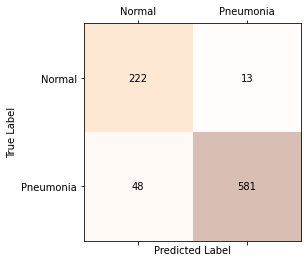

In [ ]:
# Draw Confusion matrix

fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Accent, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()

##### Denset with Imagenet weight: Accuracy on test data 92% 

## DenseNet with pre-trained CheXNet architecture weights

In [ ]:
# Set the batch size for the generator and training
BATCH_SIZE = 32

# Declare an image generator for image augmentation
datagen1 = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen1 = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen1 = datagen1.flow_from_dataframe(train_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen1 = test_datagen1.flow_from_dataframe(val_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen1 = test_datagen1.flow_from_dataframe(test_df,
                                        target_size=(224, 224),
                                        # color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [ ]:
# loading the DenseNet121 model with ChestXNet weights without the FC layers
path_to_weights = '/content/gdrive/MyDrive/Project/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
Densenet = tf.keras.applications.densenet.DenseNet121(include_top=False,input_shape=(224, 224, 3))
Densenet.load_weights(path_to_weights, by_name=True)
for layer in Densenet.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = GlobalAveragePooling2D()(Densenet.output) #flattening out the last layer
predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_CheXNet = Model(inputs=Densenet.input, outputs=predictions)
model_CheXNet.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
model_CheXNet.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('DenseNet121_CheXNet.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [ ]:
train_steps1 = train_gen1.samples // BATCH_SIZE
val_steps1 = val_gen1.samples // BATCH_SIZE

In [ ]:
history_Dense_CheXNet = model_CheXNet.fit(train_gen1,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps1,                    
                    validation_data=val_gen1,
                    validation_steps=val_steps1,                    
                    callbacks = callbacks)

Epoch 1/100
128/128 [==============================] - 2462s 19s/step - loss: 0.5345 - accuracy: 0.7300 - val_loss: 0.4698 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 86s 669ms/step - loss: 0.4492 - accuracy: 0.7684 - val_loss: 0.3892 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 86s 671ms/step - loss: 0.3908 - accuracy: 0.8294 - val_loss: 0.3427 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 85s 664ms/step - loss: 0.3523 - accuracy: 0.8677 - val_loss: 0.3098 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 85s 664ms/step - loss: 0.3273 - accuracy: 0.8793 - val_loss: 0.2875 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 6/100
128/128 [==============================] - 86s 668ms/step - loss: 0.3046 - accuracy: 0.8827 - val_loss: 0.2720 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 7/100
128/128 [=========================

In [ ]:
# # Save history in pickle file
# with open('/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

# # Load history from pickle file
# with open('/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

In [ ]:
test_steps1 = test_gen1.samples // BATCH_SIZE
model_CheXNet.evaluate(test_gen1, steps=test_steps1)

27/27 [==============================] - 415s 16s/step - loss: 0.2003 - accuracy: 0.9213


[0.2003353387117386, 0.9212962985038757]

In [ ]:
# Load saved model
model_CheXNet = tf.keras.models.load_model(filepath='DenseNet121_CheXNet.hdf5')

In [ ]:
# Calculate precision and recall based on  test data
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model_CheXNet.predict(test_gen1, steps=test_steps1).flatten()
y_pred=np.where(predictions>0.5,1,0)
y_true = test_gen1.classes[:len(predictions)]

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

print('Precision with test data:', precision.result().numpy())
print('Recall with test data:', recall.result().numpy())

27/27 [==============================] - 140s 5s/step
Precision with test data: 0.95476574
Recall with test data: 0.93958664


In [ ]:
confusion_mat = confusion_matrix(y_true, y_pred)

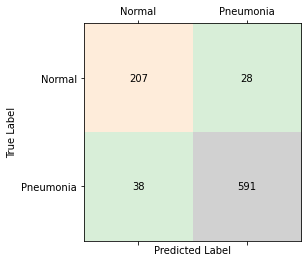

In [ ]:
# Draw Confusion matrix

fig, ax = plt.subplots()

# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
ax.matshow(confusion_mat, cmap=plt.cm.Accent, alpha=0.3)
# ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()

#### DenseNet with CheXNet (ChestXNet weight) test accuracy 92%

In [ ]:
# loading the DenseNet121 model with ChestXNet weights without the FC layers
path_to_weights = '/content/gdrive/MyDrive/Project/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
Densenet = tf.keras.applications.densenet.DenseNet121(include_top=False,input_shape=(512, 512, 3))
Densenet.load_weights(path_to_weights, by_name=True)
for layer in Densenet.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = GlobalAveragePooling2D()(Densenet.output) #flattening out the last layer
predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_CheXNet1 = Model(inputs=Densenet.input, outputs=predictions)
model_CheXNet1.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
model_CheXNet1.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('DenseNet121_CheXNet.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [ ]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [ ]:
history_Dense_CheXNet1 = model_CheXNet1.fit(train_gen,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=val_gen,
                    validation_steps=val_steps,                    
                    callbacks = callbacks)

Epoch 1/100
128/128 [==============================] - 1868s 14s/step - loss: 0.5775 - accuracy: 0.7285 - val_loss: 0.5617 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 232s 2s/step - loss: 0.5616 - accuracy: 0.7271 - val_loss: 0.5404 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 233s 2s/step - loss: 0.5449 - accuracy: 0.7273 - val_loss: 0.5274 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 234s 2s/step - loss: 0.5292 - accuracy: 0.7273 - val_loss: 0.5125 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 237s 2s/step - loss: 0.5176 - accuracy: 0.7283 - val_loss: 0.4983 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 6/100
128/128 [==============================] - 237s 2s/step - loss: 0.5037 - accuracy: 0.7317 - val_loss: 0.4874 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 7/100
128/128 [==============================] - 2

## Transfer Learning with EfficientNet

In [ ]:
EfficientNet = tf.keras.applications.EfficientNetB7(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
for layer in EfficientNet.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = GlobalAveragePooling2D()(EfficientNet.output) #flattening out the last layer
predictions = Dense(1,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model_EfficientNet = Model(inputs=EfficientNet.input, outputs=predictions)
model_EfficientNet.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambd

In [ ]:
model_EfficientNet.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 8), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('EfficientNet.hdf5', monitor='loss' , save_best_only=True) # saving the best model
    ]

In [ ]:
train_steps1 = train_gen1.samples // BATCH_SIZE
val_steps1 = val_gen1.samples // BATCH_SIZE

In [ ]:
history_EfficientNet = model_EfficientNet.fit(train_gen1,                    
                    epochs=100,                    
                    steps_per_epoch=train_steps1,                    
                    validation_data=val_gen1,
                    validation_steps=val_steps1,                    
                    callbacks = callbacks)

Epoch 1/100
128/128 [==============================] - 125s 841ms/step - loss: 0.5938 - accuracy: 0.7273 - val_loss: 0.5817 - val_accuracy: 0.7373
Epoch 2/100
128/128 [==============================] - 103s 807ms/step - loss: 0.5900 - accuracy: 0.7285 - val_loss: 0.5960 - val_accuracy: 0.7373
Epoch 3/100
128/128 [==============================] - 103s 801ms/step - loss: 0.5925 - accuracy: 0.7283 - val_loss: 0.5771 - val_accuracy: 0.7373
Epoch 4/100
128/128 [==============================] - 103s 813ms/step - loss: 0.5915 - accuracy: 0.7283 - val_loss: 0.5793 - val_accuracy: 0.7373
Epoch 5/100
128/128 [==============================] - 105s 818ms/step - loss: 0.5928 - accuracy: 0.7285 - val_loss: 0.6036 - val_accuracy: 0.7373
Epoch 6/100
128/128 [==============================] - 103s 806ms/step - loss: 0.5888 - accuracy: 0.7283 - val_loss: 0.5776 - val_accuracy: 0.7373
Epoch 7/100
128/128 [==============================] - 104s 815ms/step - loss: 0.5849 - accuracy: 0.7288 - val_loss: 0

## Summary

|Model | Train Accuracy | Val. Accuracy |
|:------|:---------------|:--------------|
|DenseNet |96.29  |	95.37|
|DenseNet with CheXNet(224X224)| 91.54  | 92.01|
|DenseNet with CheXNet(512X512)|	84.19|	85.88|
|Vgg16  |93.60|	92.25|	
|EfficientNet |	72.71|	73.73|
|ResNet |	83.21|	85.65|


**Conclusion:** From the above outcome we can say that DenseNet, DenseNet with CheXNet(224X224), Vgg16, ResNet are giving good accuracy for train & validation accuracy. Interesting observation is that with pre-trained ImageNet weights we are getting more accuracy as compared to Medical dataset weights CheXNet. So using ImageNet pre-trained weights are good in this case may be because the medical datasets are small where ImageNet pre-trained weights are large in comparision to it. Once we get the good baseline model, we also need to concentrate on hyperparameter optimization, truncating the model to reduce its size, etc. For this problem we can go with transfer learning techniques.